In [ ]:
# Import usual python numerical library
import numpy as np
# Importing standard Qiskit libraries
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Pauli
from qiskit.visualization import plot_bloch_vector, plot_distribution
from qiskit_ibm_runtime import EstimatorV2, SamplerV2
from qiskit.compiler import transpile


import matplotlib
import matplotlib.pyplot
%matplotlib inline


import subprocess
#this is so I can run the code on my computer without sharing my token online
#you can get your own token at https://quantum-computing.ibm.com/account
token = subprocess.run("echo $IBM_TOKEN", shell=True, stdout=subprocess.PIPE).stdout.decode('utf-8').strip()

# Insert your token
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True, set_as_default=True)

# List the backends available to you. 
service = QiskitRuntimeService(channel="ibm_quantum")

# Load the backend with the fewest pending jobs
service_backend = service.least_busy() 
print('Using backend:', service_backend.name)

Using backend: ibm_kyiv


# 4. Simon's Algorithm
## 4a. Run in Classical Simulator `AerSimulator`
For the two-bit string $a = 10$, Run Simon's algorithm in `AerSimulator` with `shots=1` until you can determine $a$, and report how many runs were needed to find $a$.


z:  [0 1]
Number of iterations to get z such that a \cdot{} z = 0:  1


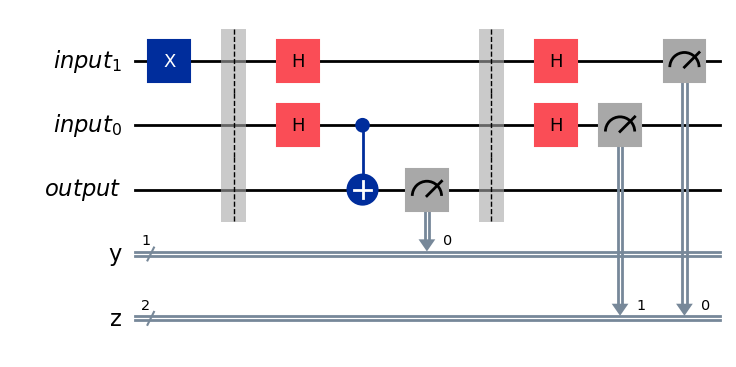

In [ ]:
a = np.array([1, 0])

input_reg = QuantumRegister(2, name='input')
output_reg = QuantumRegister(1, name='output')
z_reg = ClassicalRegister(input_reg.size, name='z')
y_reg = ClassicalRegister(output_reg.size, name='y')  

circ = QuantumCircuit(output_reg, input_reg, z_reg, y_reg)
circ.x(input_reg[1]) # to prepare the input state for a = 10 

circ.barrier()

circ.h(input_reg)

# create unitary U

U = QuantumCircuit(output_reg, input_reg, z_reg, y_reg)
U.cx(input_reg[0], output_reg[0])

circ = circ.compose(U, inplace=False)
circ.measure(output_reg, y_reg)


circ.barrier()
circ.h(input_reg)
circ.measure(input_reg[0], z_reg[1])
circ.measure(input_reg[1], z_reg[0])


circ.draw('mpl', reverse_bits=True)

simulator = AerSimulator(method='statevector')
circ_transpiled = transpile(circ, simulator)

simulator.set_options(shots=1) 


count = 1
job = simulator.run(circ_transpiled)
result = job.result().get_counts(circ_transpiled)
z = np.array([int(i) for i in list(result.keys())[0].split(' ')[1]]) # cursed way of extracting the z register from the result




while np.dot(a, z) != 0:
    job = simulator.run(circ_transpiled)
    result = job.result().get_counts(circ_transpiled)
    count += 1
    z = np.array([int(i) for i in list(result.keys())[0].split(' ')[1]])

    


print("z: ", z)
print("Number of iterations to get z such that a \\cdot{} z = 0: ", count)

## 4b. Run on Real Device
Run in a real device of your choice using a large enough number of shots in order to obtain good statistics. Use the resulting statistics to estimate: (1) The probability of measuring a wrong result $a \neq 10$ with one shot, and (2) The probability of measuring the right result $a = 10$ with one shot. 

{'11': 518, '01': 491, '00': 6, '10': 9}


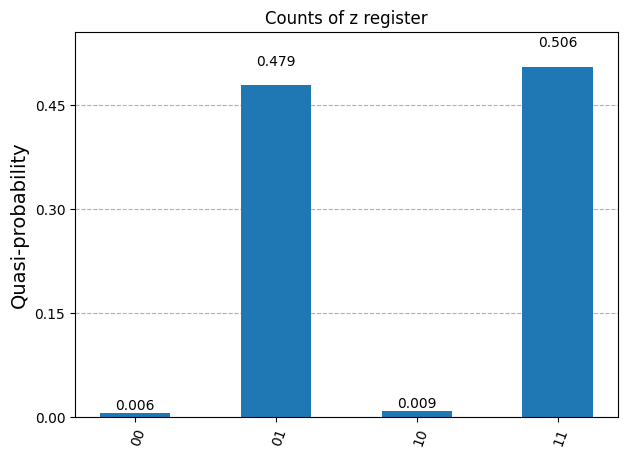

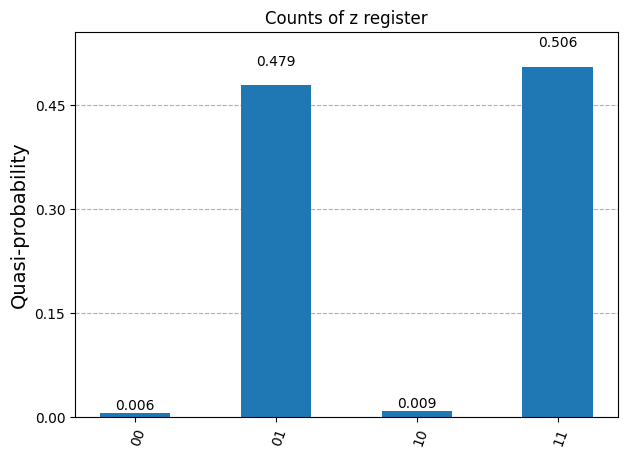

In [ ]:
# Transpile the circuit for the real device
circ_transpiled = transpile(circ, service_backend, optimization_level=3)
# Run the circuit on the real device
sampler = SamplerV2(mode=service_backend)

job = sampler.run([circ_transpiled], shots=1024)
result = job.result()

counts = result._pub_results[0].data.z.get_counts()

print(counts)
plot_distribution(counts, title="Counts of z register")


**Discussion.** 
As seen the plot above, we see that we obtain a $z = 01$ with a probability of $0.479$ and a $z \neq 01$ with a probability of $0.521$. 

This means that we have a (1) $47.9\%$ chance of measuring the correct result $a = 10$ and a (2) $52.1\%$ chance of measuring the wrong result $a \neq 10$, each in one shot.